In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import cm
from scipy.stats import mannwhitneyu

In [3]:
# Set plotting style
plt.style.use("seaborn-v0_8-white")

LINE_COLOR = "purple"

# Metadata saved to output plots
METADATA = {"Contributor": "Alexander Gude", "Rights": "CC-BY-SA 4.0"}

In [4]:
%matplotlib inline

In [5]:
# Show all columns
pd.set_option("display.max_columns", None)

In [6]:
START_YEAR = 2001
LAST_YEAR = 2020

SQL_FILE = "./v2.0.0-converted_with_sts_v4.0.0-switrs.sqlite"

In [7]:
# Date conversion function
def date_columns(query):
    """If a date column is included in the query, parse it as a date in the
    dataframe."""
    dates = []
    fields = ["collision_date", "process_date"]
    if "*" in query:
        dates = fields
    else:
        for date in fields:
            if date in query:
                dates.append(date)

        if not dates:
            dates = None

    return dates

In [8]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.


def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.

    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.

    Returns:
        (fig, ax): A Matplotlib figure and axis object.

    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)

    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL

    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"

    # Figure output
    plt.rcParams["savefig.dpi"] = 300

    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return fig, ax

In [9]:
def save_plot(fig, filename):
    """Save the plot with metadata and tight layout.

    Args:
        fig (matplotlib figure): The figure to save.
        filename (str): The loction to save the file to.

    """
    metadata = METADATA

    fig.savefig(
        fname=f"{filename}",
        bbox_inches="tight",
        metadata=metadata,
    )

# Data

In [10]:
query = (
    "SELECT collision_date, collision_time, pedestrian_killed_count "
    "FROM collisions "
    "WHERE Collision_Date IS NOT NULL "
    f"AND Collision_Date <= '{LAST_YEAR}-12-31' "
    "AND strftime('%m-%d', Collision_Date) = '10-31' "
    "AND pedestrian_Collision = 1 "
    "ORDER BY collision_date"
)


with sqlite3.connect(SQL_FILE) as con:
    df = pd.read_sql(
        query,
        con,
        parse_dates=["collision_date", "collision_time"],
    )

In [11]:
DATE_COL = "collision_date"
CRASH_COL = "crashes"

df["day_of_week"] = df[DATE_COL].dt.dayofweek
df["hour"] = df["collision_time"].dt.hour
df["is_weekend"] = df["day_of_week"].isin([5, 6])
df[CRASH_COL] = 1

In [12]:
df.head()

,collision_date,collision_time,pedestrian_killed_count,day_of_week,hour,is_weekend,crashes
0,2001-10-31,2022-11-20 06:10:00,0,2,6.0,False,1
1,2001-10-31,2022-11-20 11:30:00,0,2,11.0,False,1
2,2001-10-31,2022-11-20 12:45:00,0,2,12.0,False,1
3,2001-10-31,2022-11-20 14:52:00,0,2,14.0,False,1
4,2001-10-31,2022-11-20 01:55:00,0,2,1.0,False,1


In [13]:
from datetime import datetime


def annotate_year(
    df, ax, month, day, text, xytext_adjust, adjust=[0, 0], arrowstyle="->"
):
    """Draw an annotation on the Day of Year plot."""
    # Use 2016 because it is a leapyear, and we plot Feb 29
    doy = datetime(year=2016, month=month, day=day).timetuple().tm_yday
    y_pos = df[CRASH_COL][month][day]

    xy = (doy + adjust[0], y_pos + adjust[1])
    xytext = xy[0] + xytext_adjust[0], xy[1] + xytext_adjust[1]

    ax.annotate(
        text,
        xy,
        xytext=xytext,
        arrowprops=dict(
            arrowstyle=arrowstyle,
            connectionstyle="arc3",
        ),
        size=16,
        horizontalalignment="center",
    )

In [14]:
# Get the start locations of each month
def month_starts(df):
    """Get the start and midpoints of each month."""
    # Month starts
    majors = []
    for x, (month, day) in enumerate(df.index):
        if day == 1:
            majors.append(x)
        if month == 12 and day == 31:
            majors.append(x)

    # Midpoints
    minors = []
    for i in range(len(majors) - 1):
        end = majors[i + 1]
        start = majors[i]
        x = start + (end - start) / 2.0
        minors.append(x)

    return (majors, minors)

# Time of day

In [15]:
df_hour = df[["hour", "is_weekend", "crashes"]].groupby(["hour", "is_weekend"]).count()
df_hour = df_hour.reset_index()

# Normalize by number of days
weekend_count = df[df["is_weekend"] == True]["collision_date"].nunique()
weekday_count = df[df["is_weekend"] == False]["collision_date"].nunique()

df_hour.loc[df_hour["is_weekend"] == True, "crashes"] /= weekend_count
df_hour.loc[df_hour["is_weekend"] == False, "crashes"] /= weekday_count

x = df_hour["hour"].unique()
weekend_y = df_hour[df_hour["is_weekend"] == True]["crashes"].values
weekday_y = df_hour[df_hour["is_weekend"] == False]["crashes"].values

In [16]:
df_hour.head()

,hour,is_weekend,crashes
0,0.0,False,0.600000
1,0.0,True,1.200000
2,1.0,False,0.533333
3,1.0,True,2.000000
4,2.0,False,0.533333


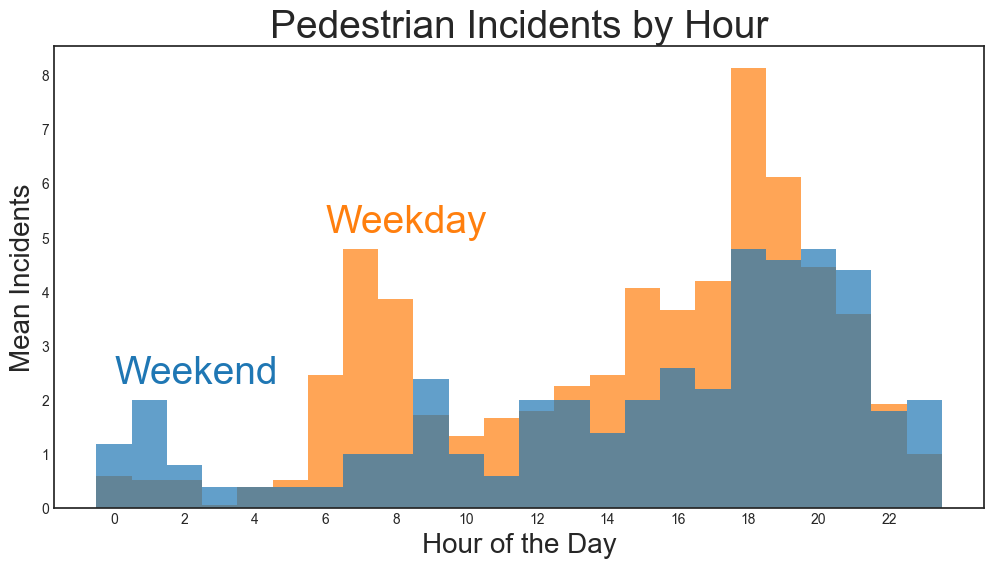

In [17]:
# Set plotting style
plt.style.use("seaborn-v0_8-white")

# Set plot size
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(12, 6)

plt.hist(
    x=[x, x],
    bins=np.arange(0, 25, 1),
    weights=[weekend_y, weekday_y],
    histtype="stepfilled",
    align="left",
    alpha=0.7,
)

# Set plot title
plt.title("Pedestrian Incidents by Hour", size=28)
plt.ylabel("Mean Incidents", size=20)
plt.xlabel("Hour of the Day", size=20)

# Plot text
WEEKEND_COLOR = "C0"
WEEKDAY_COLOR = "C1"
ax.text(
    0,
    2.3,
    "Weekend",
    fontsize=28,
    color=WEEKEND_COLOR,
)  # C0 is the first default color
ax.text(
    6,
    5.1,
    "Weekday",
    fontsize=28,
    color=WEEKDAY_COLOR,
)


# Set X tick labels
ax.set_xticks(np.arange(0, 24, 2))

for ext in ("png", "svg"):
    plt.savefig(
        "/tmp/pedestrian_incidents_by_hour_on_halloween.{ext}".format(ext=ext),
        bbox_inches="tight",
    )

## Fatalities

In [18]:
query = """
SELECT collision_date
     , collision_time
     , CASE 
         WHEN victim_age < 18 THEN 1 
                                                    ELSE 0 
         END AS pedestrian_is_a_minor 
     , CASE 
         WHEN victim_degree_of_injury = 'killed' THEN 1 
                                                                                  ELSE 0 
         END AS pedestrian_killed_count 
FROM collisions 
INNER JOIN parties 
ON collisions.case_id = parties.case_id 
INNER JOIN victims 
ON collisions.case_id = victims.case_id 
WHERE Collision_Date IS NOT NULL 
AND Collision_Date <= '{LAST_YEAR}-12-31' 
AND strftime('%m-%d', Collision_Date) = '10-31' 
AND pedestrian_Collision = 1 
AND victims.victim_role = 'pedestrian'
"""

with sqlite3.connect(SQL_FILE) as con:
    df_fatalities = pd.read_sql(
        query,
        con,
        parse_dates=["collision_date", "collision_time"],
    )

In [19]:
df_fatalities

,collision_date,collision_time,pedestrian_is_a_minor,pedestrian_killed_count
0,2009-10-31,2022-11-20 05:30:00,0,1
1,2009-10-31,2022-11-20 05:30:00,0,1
2,2009-10-31,2022-11-20 07:48:00,0,0
3,2009-10-31,2022-11-20 07:48:00,0,0
4,2009-10-31,2022-11-20 22:58:00,0,0
...,...,...,...,...
2790,2001-10-31,2022-11-20 17:50:00,1,0
2791,2001-10-31,2022-11-20 20:30:00,1,0
2792,2001-10-31,2022-11-20 20:30:00,1,0
2793,2001-10-31,2022-11-20 20:30:00,1,0


In [20]:
df_fatalities["day_of_week"] = df_fatalities[DATE_COL].dt.dayofweek
df_fatalities["is_weekend"] = df_fatalities["day_of_week"].isin([5, 6])

### All People

In [21]:
# Count accidents per day, and then reset the index so we can pivot on the index
DOW_COL = "day_of_week"

df_all = (
    df_fatalities[[DATE_COL, DOW_COL, "pedestrian_killed_count"]]
    .groupby([DATE_COL, DOW_COL])
    .agg(
        # Max of all the same value just selects one
        {"pedestrian_killed_count": ["mean"]}
    )
    .droplevel(level=0, axis="columns")
)
df_all = df_all.reset_index()
df_all["is_weekend"] = df_all[DOW_COL].isin([5, 6])

In [22]:
df_all.head()

,collision_date,day_of_week,mean,is_weekend
0,2001-10-31,2,0.046296,False
1,2002-10-31,3,0.083871,False
2,2003-10-31,4,0.000000,False
3,2004-10-31,6,0.109756,True
4,2005-10-31,0,0.036585,False


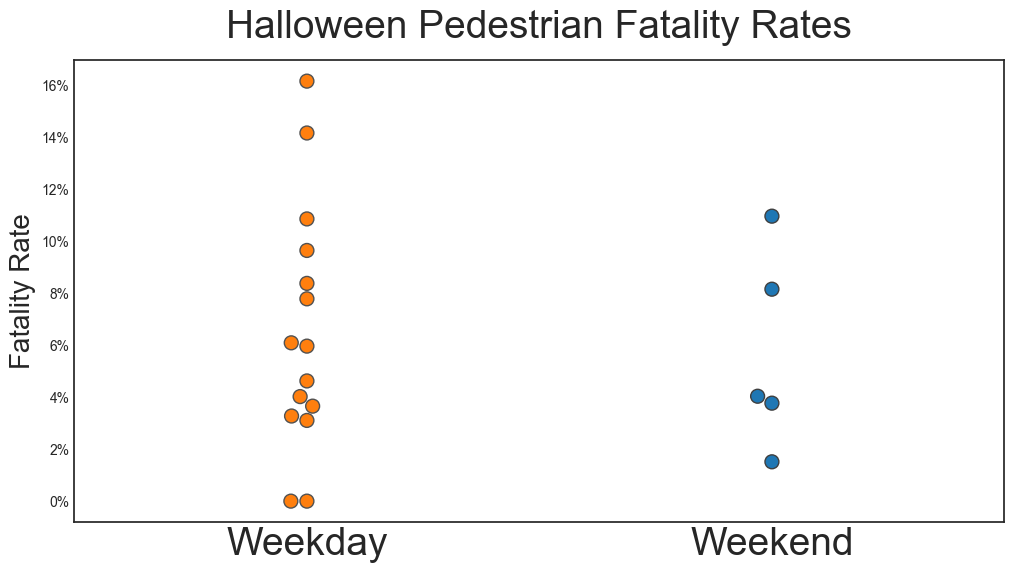

In [31]:
# Set plotting style
plt.style.use("seaborn-v0_8-white")

# Set plot size
fig = plt.gcf()
fig.set_size_inches(12, 6)


ax = sns.swarmplot(
    x="is_weekend",
    y="mean",
    hue="is_weekend",
    palette=[WEEKDAY_COLOR, WEEKEND_COLOR],
    data=df_all,
    linewidth=1,
    size=10,
    legend=False,
)

# Set plot title
plt.title("Halloween Pedestrian Fatality Rates", y=1.03, size=28)

# Set Y and X range
# plt.gca().set_ylim([0, 3000])
plt.ylabel("Fatality Rate", fontsize=20)
plt.xlabel("")

# Format percents for Y axis
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# Set X tick labels
ax.set_xticks([0, 1])  # Avoid "UserWarning: FixedFormatter should only..." error
ax.set_xticklabels(["Weekday", "Weekend"], size=28)

for ext in ("png", "svg"):
    plt.savefig(
        "/tmp/pedestrian_fatality_rate_by_day_type_on_halloween.{ext}".format(ext=ext),
        bbox_inches="tight",
    )

In [24]:
mannwhitneyu(
    x=df_all[df_all["is_weekend"] == True]["mean"],
    y=df_all[df_all["is_weekend"] == False]["mean"],
)

MannwhitneyuResult(statistic=36.0, pvalue=0.930417165518429)

### Under 18

In [25]:
# Count accidents per day, and then reset the index so we can pivot on the index
DOW_COL = "day_of_week"

df_children = (
    df_fatalities[df_fatalities["pedestrian_is_a_minor"] == 1][
        [DATE_COL, DOW_COL, "pedestrian_killed_count"]
    ]
    .groupby([DATE_COL, DOW_COL])
    .agg(
        # Max of all the same value just selects one
        {"pedestrian_killed_count": ["mean"]}
    )
    .droplevel(level=0, axis="columns")
)
df_children = df_children.reset_index()
df_children["is_weekend"] = df_children[DOW_COL].isin([5, 6])

In [26]:
df_children.head()

,collision_date,day_of_week,mean,is_weekend
0,2001-10-31,2,0.096774,False
1,2002-10-31,3,0.000000,False
2,2003-10-31,4,0.000000,False
3,2004-10-31,6,0.000000,True
4,2005-10-31,0,0.029412,False


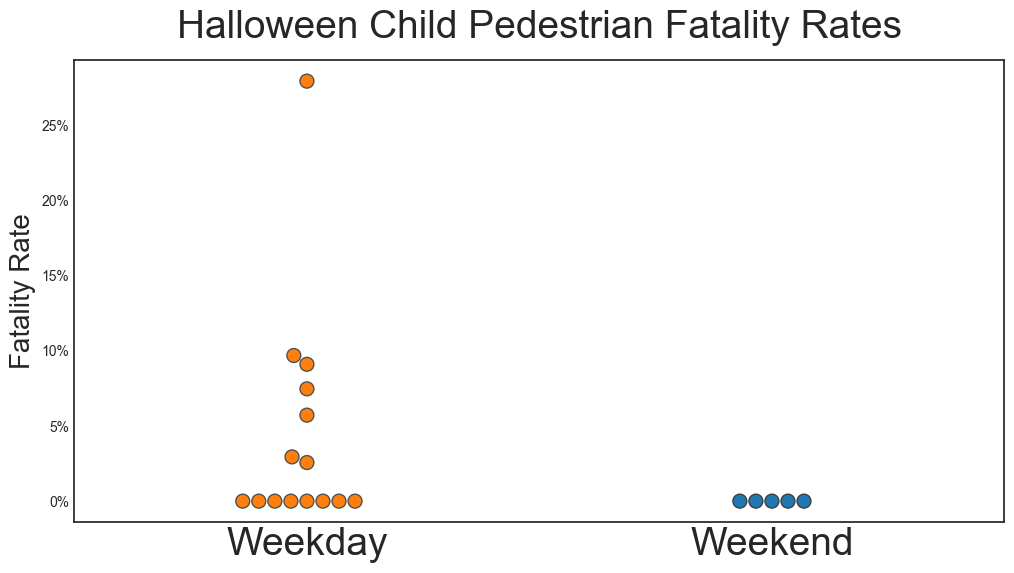

In [30]:
# Set plotting style
plt.style.use("seaborn-v0_8-white")

# Set plot size
fig = plt.gcf()
fig.set_size_inches(12, 6)


ax = sns.swarmplot(
    x="is_weekend",
    y="mean",
    hue="is_weekend",
    palette=[WEEKDAY_COLOR, WEEKEND_COLOR],
    data=df_children,
    linewidth=1,
    size=10,
    legend=False,
)

# Set plot title
plt.title("Halloween Child Pedestrian Fatality Rates", y=1.03, size=28)

# Set Y and X range
# plt.gca().set_ylim([0, 3000])
plt.ylabel("Fatality Rate", fontsize=20)
plt.xlabel("")

# Format percents for Y axis
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))

# Set X tick labels
ax.set_xticks([0, 1])  # Avoid "UserWarning: FixedFormatter should only..." error
ax.set_xticklabels(["Weekday", "Weekend"], size=28)

for ext in ("png", "svg"):
    plt.savefig(
        "/tmp/children_pedestrian_fatality_rate_by_day_type_on_halloween.{ext}".format(
            ext=ext
        ),
        bbox_inches="tight",
    )

In [28]:
mannwhitneyu(
    x=df_children[df_children["is_weekend"] == True]["mean"],
    y=df_children[df_children["is_weekend"] == False]["mean"],
)

MannwhitneyuResult(statistic=20.0, pvalue=0.08165705327193112)